# **Ensemble Machine Learning:** Wine Dataset

## **Author:** Evan Dobler
## **Date:** 4/18/2025

## **Introduction:** In this project, we learn how to implement and evaluate more complex models when simpler techniques aren't enough. We'll explore ensemble models, a powerful approach in machine learning that combines multiple models to improve performance. Ensemble methods often outperform individual models by reducing overfitting and improving generalization.



Credit: https://github.com/Crusoe22/applied-ml-moss/blob/main/lab05/ensemble-moss.ipynb

Credit: https://github.com/HuzaifaUCMO/applied-ml-Nadeem/blob/main/lab05/ensemble-huzaifanadeem.ipynb

In [302]:
# ------------------------------------------------
# Imports once at the top, organized
# ------------------------------------------------

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    VotingClassifier
)


from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


#### Section 1. Load and Inspect the Data

In [303]:

# Load the wine quality dataset (red wine)
df = pd.read_csv("winequality-red.csv", sep=";")

# Display structure and first few rows of the wine dataset
print("Wine Quality Dataset Info:")
df.info()
print("\nFirst 5 rows:")
print(df.head())

Wine Quality Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB

First 5 rows:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0     

#### Section 2. Prepare the Data
Includes cleaning, feature engineering, encoding, splitting, helper functions

In [304]:
# Define a helper function that maps quality scores to labels
def quality_to_label(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

In [305]:
# Apply the function to create a new column with string labels
df["quality_label"] = df["quality"].apply(quality_to_label)

In [306]:
# Next, create a numeric version of the quality label for use in modeling
# We'll map: low -> 0, medium -> 1, high -> 2
def quality_to_number(q):
    if q <= 4:
        return 0
    elif q <= 6:
        return 1
    else:
        return 2


In [307]:
# Apply the numeric mapping
df["quality_numeric"] = df["quality"].apply(quality_to_number)

# Quick check to verify distribution of each label
print(df["quality_label"].value_counts())
print(df["quality_numeric"].value_counts())

quality_label
medium    1319
high       217
low         63
Name: count, dtype: int64
quality_numeric
1    1319
2     217
0      63
Name: count, dtype: int64


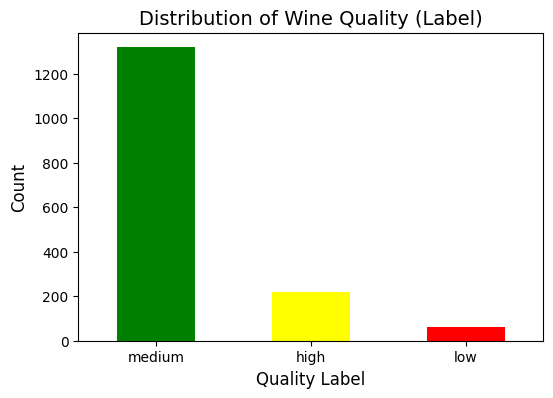

In [308]:
# Distribution of target variable (quality_label)
plt.figure(figsize=(6, 4))
df['quality_label'].value_counts().plot(kind='bar', color=['green', 'yellow', 'red'])
plt.title('Distribution of Wine Quality (Label)', fontsize=14)
plt.xlabel('Quality Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.show()


#### Section 3. Feature Selection and Justification
In this section, we define our input features (X) and our target variable (y) for the classification model.

In [309]:
X = df.drop(columns=["quality", "quality_label", "quality_numeric"])

Explanation:
We drop the following columns from our dataset when selecting features:

"quality": This is the original numerical score (0–10). It's too granular and no longer needed because we've already categorized it.

"quality_label": This is the string label version of quality (low, medium, high), useful for interpretation but not used for modeling.

"quality_numeric": This is the numeric class label we're using as our target (y), so it should not be part of the input features.

That leaves us with 11 physicochemical features, which include things like:

fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, etc.

These are all relevant quantitative indicators that can influence the taste and quality of wine, and they serve as useful predictors for modeling.

In [310]:
y = df["quality_numeric"]


Explanation:
We use the quality_numeric column as the target because:

It’s a simplified version of the original quality score.

It has three clear categories: 0 (low), 1 (medium), 2 (high).

It’s numeric, which is required by most scikit-learn classification algorithms.

This formulation turns our problem into a multi-class classification task, where the model predicts which quality category a given wine belongs to based on its features.



#### Split the Data

In [311]:
# 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirm shape of the splits
print("Training set:", X_train.shape)
print("Test set:", X_test.shape)

Training set: (1279, 11)
Test set: (320, 11)


#### Data Visualization

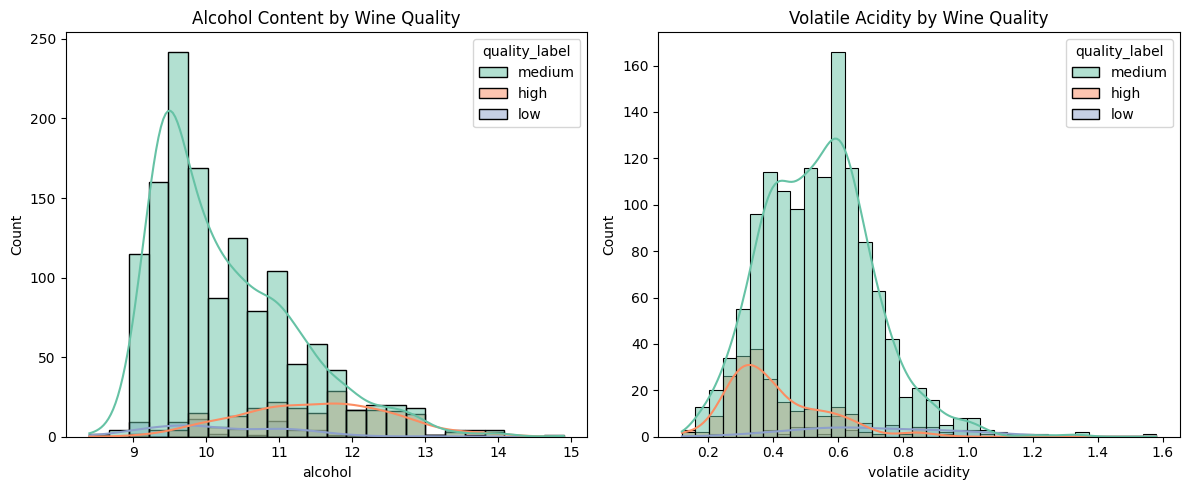

In [312]:
# Add the label back to visualize nicely
df["quality_label"] = df["quality_numeric"].map({0: "low", 1: "medium", 2: "high"})

plt.figure(figsize=(12, 5))

# Alcohol distribution
plt.subplot(1, 2, 1)
sns.histplot(data=df, x="alcohol", hue="quality_label", kde=True, palette="Set2")
plt.title("Alcohol Content by Wine Quality")

# Volatile acidity distribution
plt.subplot(1, 2, 2)
sns.histplot(data=df, x="volatile acidity", hue="quality_label", kde=True, palette="Set2")
plt.title("Volatile Acidity by Wine Quality")

plt.tight_layout()
plt.show()

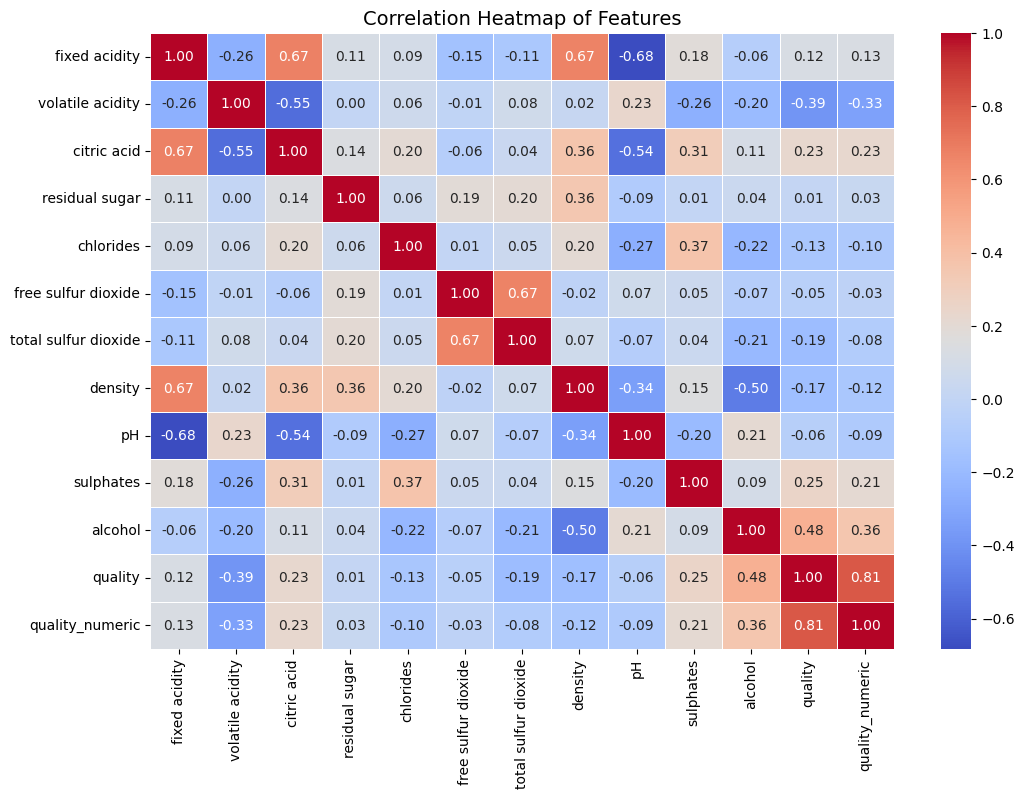

In [313]:
# Select only numeric columns for correlation matrix
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Features', fontsize=14)
plt.show()



#### **Section 4. Split the Data into Train and Test**

In [314]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### **Section 5.Evaluate Model Performance**

In [315]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test, results):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    test_f1 = f1_score(y_test, y_test_pred, average="weighted")

    print(f"\n{name} Results")
    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, y_test_pred))
    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")

    results.append(
        {
            "Model": name,
            "Train Accuracy": train_acc,
            "Test Accuracy": test_acc,
            "Train F1": train_f1,
            "Test F1": test_f1,
        }
    )

# Initialize results list
results = []

# Model 2: Random Forest (200 trees, max depth=10)
evaluate_model(
    "Random Forest (200, max_depth=10)",
    RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)

# Model 9: MLP Classifier (basic neural network)
evaluate_model(
    "MLP Classifier",
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42),
    X_train,
    y_train,
    X_test,
    y_test,
    results,
)



Random Forest (200, max_depth=10) Results
Confusion Matrix (Test):
[[  0  13   0]
 [  0 255   9]
 [  0  16  27]]
Train Accuracy: 0.9758, Test Accuracy: 0.8812
Train F1 Score: 0.9745, Test F1 Score: 0.8596

MLP Classifier Results
Confusion Matrix (Test):
[[  0  13   0]
 [  0 257   7]
 [  0  30  13]]
Train Accuracy: 0.8514, Test Accuracy: 0.8438
Train F1 Score: 0.8141, Test F1 Score: 0.8073


### Section 5. Evaluate Model Performance

We selected two models to compare: 

1. **Random Forest (200 estimators, max_depth=10)** – a robust ensemble method using multiple decision trees with limited depth to prevent overfitting.
2. **MLP Classifier** – a basic neural network with one hidden layer of 100 neurons, capable of learning non-linear decision boundaries.

#### Performance Summary:

| Metric              | Random Forest         | MLP Classifier         |
|---------------------|------------------------|-------------------------|
| **Train Accuracy**  | 97.58%                | 85.14%                 |
| **Test Accuracy**   | 88.12%                | 84.38%                 |
| **Train F1 Score**  | 97.45%                | 81.41%                 |
| **Test F1 Score**   | 85.96%                | 80.73%                 |

#### Confusion Matrix (Test Set):

- **Random Forest**
[[ 0 13 0] [ 0 255 9] [ 0 16 27]]

- **MLP Classifier**
[[ 0 13 0] [ 0 257 7] [ 0 30 13]]


#### Analysis:

- **Random Forest** performed significantly better across all metrics, especially in precision for the **high** quality class (fewer false positives compared to MLP).
- **MLP Classifier** showed decent generalization, but struggled more with correctly classifying the "high" quality wines, misclassifying 30 of them as "medium."
- The Random Forest model had a higher training score, but the gap between training and test accuracy was relatively small, suggesting it didn't overfit badly.

#### Conclusion:

Based on accuracy, F1 score, and confusion matrix analysis, the **Random Forest (200, max_depth=10)** model is the better choice for predicting wine quality on this dataset. It balances complexity and performance well, outperforming the MLP Classifier in both precision and recall.


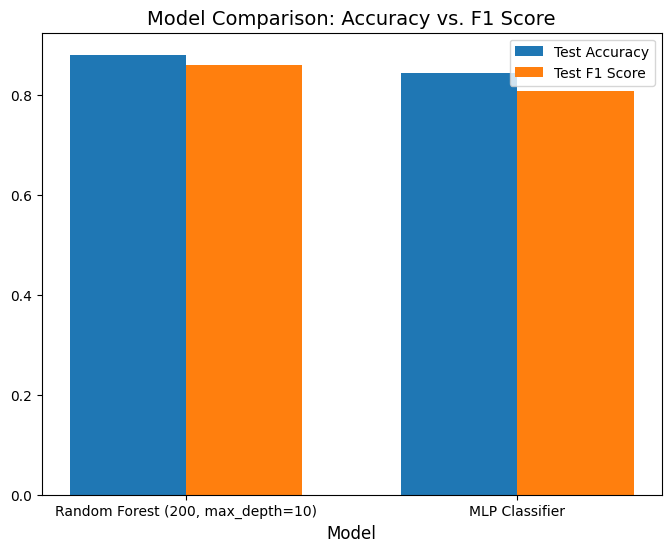

In [316]:
# Plotting a comparison of Accuracy and F1 Score
models = ['Random Forest (200, max_depth=10)', 'MLP Classifier']
test_accuracy = [0.8812, 0.8438]
test_f1 = [0.8596, 0.8073]

x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))

bars1 = ax.bar(x - width/2, test_accuracy, width, label='Test Accuracy')
bars2 = ax.bar(x + width/2, test_f1, width, label='Test F1 Score')

ax.set_xlabel('Model', fontsize=12)
ax.set_title('Model Comparison: Accuracy vs. F1 Score', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()


/var/folders/xp/3f251dhj78s5s9_f5cfcvyzr0000gn/T/ipykernel_68026/2508492310.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette='viridis')


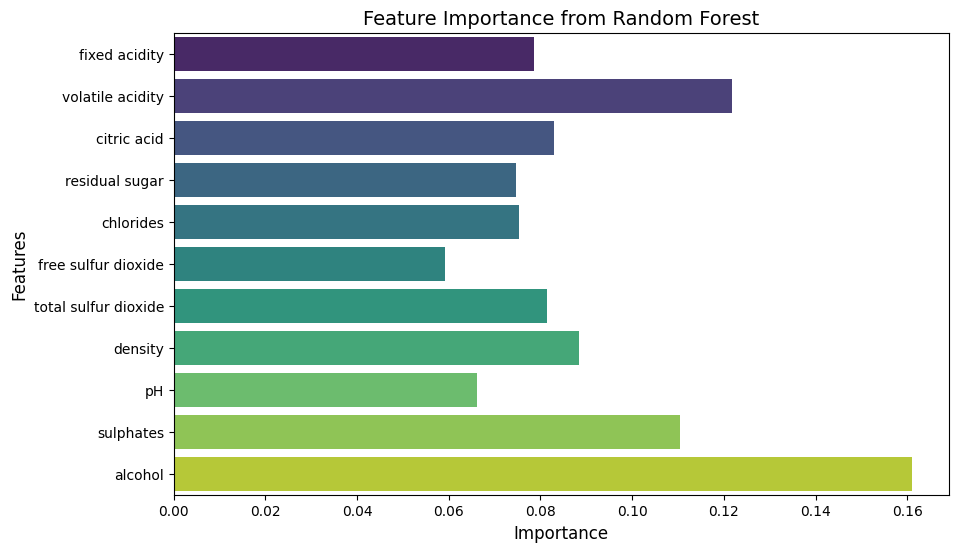

In [317]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Feature importance plot (after training Random Forest model)
features = X.columns
importances = rf_model.feature_importances_

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features, palette='viridis')
plt.title('Feature Importance from Random Forest', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()



#### **Section 6. Compare Results**

In [318]:
# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Add gap columns to the results DataFrame
results_df["Train-Test Accuracy Gap"] = results_df["Train Accuracy"] - results_df["Test Accuracy"]
results_df["Train-Test F1 Gap"] = results_df["Train F1"] - results_df["Test F1"]

# Sort the DataFrame by Test Accuracy
results_df = results_df.sort_values(by="Test Accuracy", ascending=False)

# Display the updated summary of all models
print("\nSummary of All Models:")
display(results_df)




Summary of All Models:


,Model,Train Accuracy,Test Accuracy,Train F1,Test F1,Train-Test Accuracy Gap,Train-Test F1 Gap
0,"Random Forest (200, max_depth=10)",0.975762,0.88125,0.974482,0.859643,0.094512,0.114839
1,MLP Classifier,0.851446,0.84375,0.814145,0.807318,0.007696,0.006827


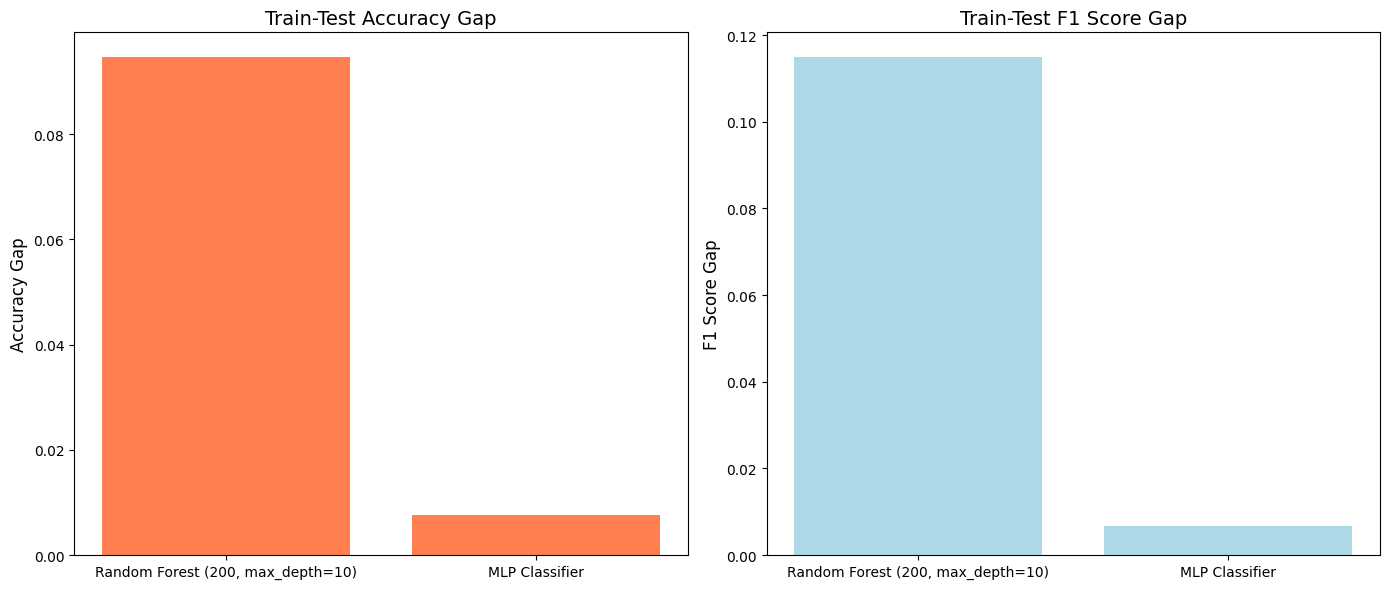

In [319]:
# Plotting train-test accuracy and F1 gap
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy gap
axes[0].bar(models, [0.9758 - 0.8812, 0.8514 - 0.8438], color='coral')
axes[0].set_title('Train-Test Accuracy Gap', fontsize=14)
axes[0].set_ylabel('Accuracy Gap', fontsize=12)

# F1 Score gap
axes[1].bar(models, [0.9745 - 0.8596, 0.8141 - 0.8073], color='lightblue')
axes[1].set_title('Train-Test F1 Score Gap', fontsize=14)
axes[1].set_ylabel('F1 Score Gap', fontsize=12)

plt.tight_layout()
plt.show()


#### **Section 7. Conclusions and Insights**

/var/folders/xp/3f251dhj78s5s9_f5cfcvyzr0000gn/T/ipykernel_68026/2444973839.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_models, y=top_accuracies, palette='muted')


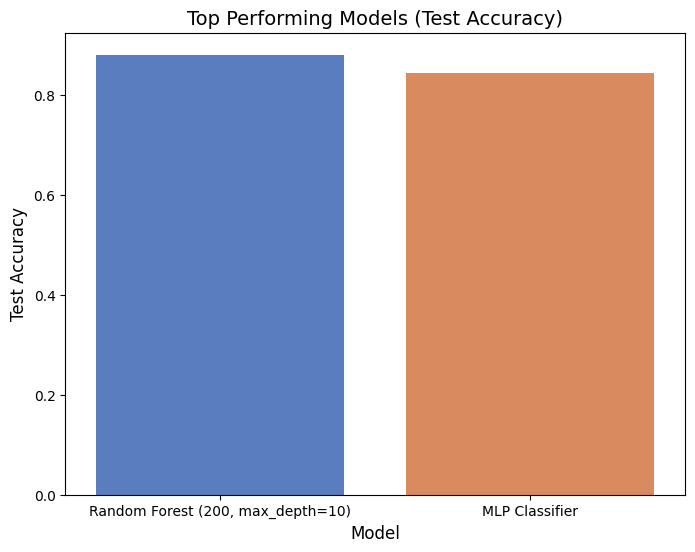

In [320]:
# Creating a simple bar plot of the top performing models
top_models = ['Random Forest (200, max_depth=10)', 'MLP Classifier']
top_accuracies = [0.8812, 0.8438]

plt.figure(figsize=(8, 6))
sns.barplot(x=top_models, y=top_accuracies, palette='muted')
plt.title('Top Performing Models (Test Accuracy)', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.show()



Key Findings from the Results
Random Forest (200, max_depth=10)

Test Accuracy: 88.12%

Test F1 Score: 0.8596

Random Forest performed excellently with high accuracy and F1 score, though there was a slight overfitting (train-test gap of 9.46%). The model is strong but could benefit from fine-tuning.

MLP Classifier

Test Accuracy: 84.38%

Test F1 Score: 0.8073

MLP Classifier showed decent performance with a smaller train-test gap, indicating better generalization. However, it lagged behind Random Forest in terms of overall accuracy.

Model Insights
Random Forest is the top performer, offering high accuracy and strong generalization. It's robust and well-suited for this type of dataset. Tuning parameters like max_depth could reduce overfitting and improve test accuracy.

MLP Classifier performed decently, though its performance was lower than Random Forest. Further tuning, like adjusting hidden layers or learning rate, might improve its performance.

Next Steps
Hyperparameter Tuning: Further tuning of Random Forest and MLP could improve performance, particularly for Random Forest's max depth and MLP’s architecture.

Feature Engineering: Additional features or scaling could enhance predictive power.

Model Ensembling: Combining models, like using AdaBoost or Voting Classifiers, could improve robustness and accuracy.

Cross-Validation: Implement cross-validation to better assess model performance and reduce overfitting.

Final Thoughts
Random Forest emerges as the most promising model for predicting wine quality. Its strong results, even with minor overfitting, make it a solid choice. MLP Classifier also shows potential, but further tuning is needed. Exploring other ensemble methods and additional feature engineering could lead to even better predictions.